# Train on the BALLROOM, GTZAN, and HAINSWORTH datasets

The goal of this notebook is to train a BeatFinder model on the BALLROOM, GTZAN, and HAINSWORTH dataset. We keep a validation set consisting of 20% of the BALLROOM dataset.

In [1]:
import beatfinder
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
totensor = beatfinder.model.ToTensor(device)
print(f'Device: {device}')

Device: cuda


## Make abstract datasets

This section only needs to be run once. The precomputation part takes a substantial amount of time.

In [ ]:
# BALLROOM dataset

# Make a validation dataset
audio_files   = './data/raw-datasets/BALLROOM/valid_audio_files.txt'
where_to_save = './data/abstract-datasets/ballroom/valid/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make a training dataset
audio_files   = './data/raw-datasets/BALLROOM/train_audio_files.txt'

# no augmentation
where_to_save = './data/abstract-datasets/ballroom/train/normal'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# first augmented
where_to_save = './data/abstract-datasets/ballroom/train/augmented_1'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# second augmented
where_to_save = './data/abstract-datasets/ballroom/train/augmented_2'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# third augmented
audio_files   = './data/raw-datasets/BALLROOM/train_audio_files.txt'
where_to_save = './data/abstract-datasets/ballroom/train/augmented_3'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

In [ ]:
# GTZAN dataset

# Make a validation dataset
audio_files   = './data/raw-datasets/GTZAN/valid_audio_files.txt'
where_to_save = './data/abstract-datasets/gtzan/valid/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make a training dataset
audio_files   = './data/raw-datasets/GTZAN/train_audio_files.txt'

# no augmentation
where_to_save = './data/abstract-datasets/gtzan/train/normal/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# first augmented
where_to_save = './data/abstract-datasets/gtzan/train/augmented_1/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# second augmented
where_to_save = './data/abstract-datasets/gtzan/train/augmented_2/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

In [ ]:
# HAINSWORTH dataset

# Make a validation dataset
audio_files   = './data/raw-datasets/HAINSWORTH/valid_audio_files.txt'
where_to_save = './data/abstract-datasets/hainsworth/valid/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make a training dataset
audio_files   = './data/raw-datasets/HAINSWORTH/train_audio_files.txt'

# no augmentation
where_to_save = './data/abstract-datasets/hainsworth/train/normal/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# first augmented
where_to_save = './data/abstract-datasets/hainsworth/train/augmented_1/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# second augmented
where_to_save = './data/abstract-datasets/hainsworth/train/augmented_2/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

Make trainset and validset

In [ ]:
ballroom_validset      = beatfinder.data.load_dataset('./data/abstract-datasets/ballroom/valid/dataset.ab')
ballroom_trainset_norm = beatfinder.data.load_dataset('./data/abstract-datasets/ballroom/train/normal/dataset.ab')
ballroom_trainset_aug1 = beatfinder.data.load_dataset('./data/abstract-datasets/ballroom/train/augmented_1/dataset.ab')
ballroom_trainset_aug2 = beatfinder.data.load_dataset('./data/abstract-datasets/ballroom/train/augmented_2/dataset.ab')
ballroom_trainset      = ballroom_trainset_norm + ballroom_trainset_aug1 + ballroom_trainset_aug2

In [ ]:
gtzan_validset      = beatfinder.data.load_dataset('./data/abstract-datasets/gtzan/valid/dataset.ab')
gtzan_trainset_norm = beatfinder.data.load_dataset('./data/abstract-datasets/gtzan/train/normal/dataset.ab')
gtzan_trainset_aug1 = beatfinder.data.load_dataset('./data/abstract-datasets/gtzan/train/augmented_1/dataset.ab')
gtzan_trainset_aug2 = beatfinder.data.load_dataset('./data/abstract-datasets/gtzan/train/augmented_2/dataset.ab')
gtzan_trainset      = gtzan_trainset_norm + gtzan_trainset_aug1 + gtzan_trainset_aug2
gtzan               = gtzan_validset + gtzan_trainset

In [ ]:
hainsworth_validset      = beatfinder.data.load_dataset('./data/abstract-datasets/hainsworth/valid/dataset.ab')
hainsworth_trainset_norm = beatfinder.data.load_dataset('./data/abstract-datasets/hainsworth/train/normal/dataset.ab')
hainsworth_trainset_aug1 = beatfinder.data.load_dataset('./data/abstract-datasets/hainsworth/train/augmented_1/dataset.ab')
hainsworth_trainset_aug2 = beatfinder.data.load_dataset('./data/abstract-datasets/hainsworth/train/augmented_2/dataset.ab')
hainsworth_trainset      = hainsworth_trainset_norm + hainsworth_trainset_aug1 + hainsworth_trainset_aug2
hainsworth               = hainsworth_validset + hainsworth_trainset


In [ ]:
trainset = ballroom_trainset + gtzan + hainsworth
validset = ballroom_validset

In [ ]:
print(f'trainset size: {len(trainset)}')
print(f'validset size: {len(validset)}')

In [ ]:
trainset.save('./data/abstract-datasets/tmp/trainset.ab')
validset.save('./data/abstract-datasets/tmp/validset.ab')

In [ ]:
# Compute the spectrograms, onsets, and isbeat. This can a substantial amount of time, but only needs to be done once.
trainset.precompute()
validset.precompute()

In [ ]:
# Remove bad samples where not enough onsets are close to a beats or no beat is recorded.
trainset.clean()
trainset.save('./data/abstract-datasets/tmp/trainset-cleaned.ab')

## Load datasets

In [2]:
trainset = beatfinder.data.load_dataset('./data/abstract-datasets/tmp/trainset-cleaned.ab')
validset = beatfinder.data.load_dataset('./data/abstract-datasets/tmp/validset.ab')

In [3]:
print(f'trainset size: {len(trainset)}')
print(f'validset size: {len(validset)}')

trainset size: 12339
validset size: 420


## Check an example

8363/12339
         Name: Media-104308.002
Song duration: 38.96
      Stretch: 1.2257
       Offset: 3.6043


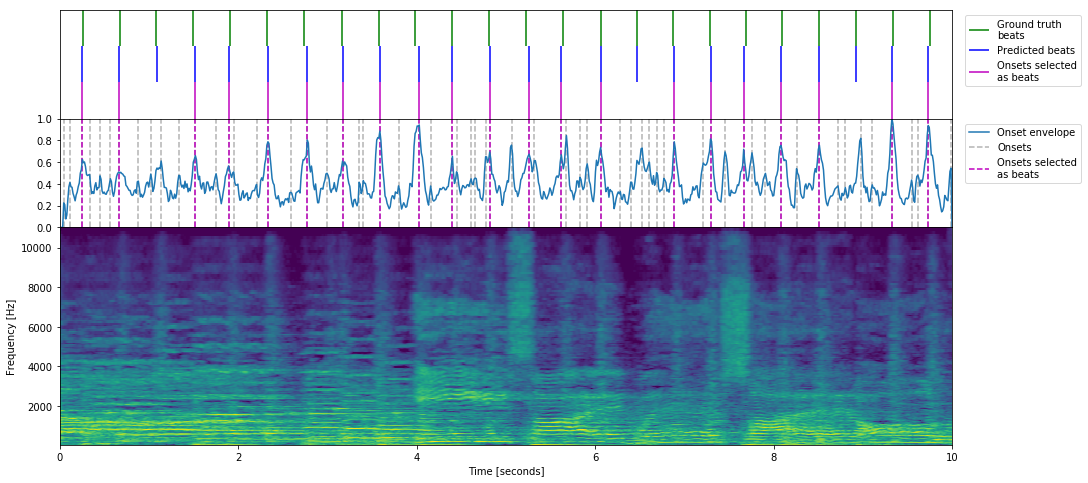

In [4]:
dataset = trainset
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
audiobeats = dataset[i]
print(f'         Name: {audiobeats.name}')
print(f'Song duration: {audiobeats.song_duration:.2f}')
print(f'      Stretch: {audiobeats.stretch:.4f}')
print(f'       Offset: {audiobeats.offset:.4f}')
beatfinder.display.showdata(audiobeats)

## Setup datasets for pytorch

In [5]:
trainset.transform = totensor
validset.transform = totensor

## Find the learning rate

I use Leslie Smith's technique proposed in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) which I learned in the [fast.ai](https://course.fast.ai/index.html) course by Jeremy Howard. The idea is to increase the learning rate at each minibatch and plot the loss over time. The ideal learning rate is when the loss decreases the most.

In [8]:
model = beatfinder.model.BeatFinder()
model.to(device)

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

Make a dataloader and an array of learning rates of the same size (one learning rate for each minibatch). The learning rates start very small and increase exponentially.

In [9]:
dataloader = DataLoader(trainset, batch_size=128, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(1, 5, 4 / n_mb))[::-1]
print(f'{len(lr)} learning rates')

97 mini batches
97 learning rates


Start the training.

In [10]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    model.set_lr(lr[i])
    tn, fp, fn, tp, loss = model.learn(specs, onsets, isbeat)
    losses[i] = loss
    print(f'{i + 1}/{n_mb}', end='\r')

Plot the loss.

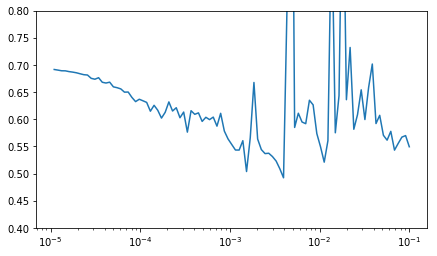

In [11]:
plt.figure(figsize=(7, 4))
plt.ylim(0.4, 0.8)
plt.semilogx(lr, losses);

Something like `lr = 0.0008` seems ideal.

## Train

In [12]:
model = beatfinder.model.BeatFinder(lr=0.0008)
model.to(device)
print(model)
model.eval()
model.freeze()

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)


In [13]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 ---------------------
| tp: 4102 | fp: 5868 |
| fn: 4396 | tn: 9296 |
 ---------------------
 Accuracy: 0.5662
Precision: 0.4114
   Recall: 0.4827
F-measure: 0.4442
     Loss: 0.6925


In [14]:
model.unfreeze()
model.train();

The loss tends to make huge jumps at unpredictable times. I should investigate more about why does it do this. But in the mean time, to circumvent this problem, I stop the training whenever the training loss goes below 0.24.

In [15]:
train_hist, valid_hist = model.fit(trainset, validset, batch_size=128, epochs=30, early_stop=0.24)

|  1 | L: 0.451 0.385 | F: 0.639 0.755 | A: 0.788 0.831 | 2.11 s/b | 0:03:24 | ETA: 1:39:03 |
|  2 | L: 0.352 0.355 | F: 0.761 0.786 | A: 0.849 0.846 | 2.16 s/b | 0:03:29 | ETA: 1:37:50 |
|  3 | L: 0.328 0.348 | F: 0.784 0.784 | A: 0.862 0.850 | 2.21 s/b | 0:03:33 | ETA: 1:36:15 |
|  4 | L: 0.309 0.354 | F: 0.798 0.783 | A: 0.871 0.847 | 2.17 s/b | 0:03:30 | ETA: 1:31:00 |
|  5 | L: 0.304 0.366 | F: 0.803 0.770 | A: 0.874 0.845 | 2.20 s/b | 0:03:32 | ETA: 1:28:43 |
|  6 | L: 0.296 0.343 | F: 0.809 0.789 | A: 0.878 0.857 | 2.22 s/b | 0:03:35 | ETA: 1:26:02 |
|  7 | L: 0.321 0.363 | F: 0.785 0.773 | A: 0.863 0.846 | 2.17 s/b | 0:03:30 | ETA: 1:20:30 |
|  8 | L: 0.313 0.346 | F: 0.796 0.785 | A: 0.869 0.855 | 2.16 s/b | 0:03:29 | ETA: 1:16:53 |
|  9 | L: 0.354 0.373 | F: 0.755 0.757 | A: 0.847 0.839 | 2.21 s/b | 0:03:34 | ETA: 1:14:59 |
| 10 | L: 0.317 0.352 | F: 0.791 0.781 | A: 0.867 0.849 | 2.21 s/b | 0:03:34 | ETA: 1:11:22 |
| 11 | L: 0.290 0.322 | F: 0.812 0.790 | A: 0.880 0.860 | 2.

In [17]:
torch.save(model.state_dict(), './data/pretrained-models/model_12.pt')
np.save('./data/pretrained-models/model_12_train_hist.npy', train_hist)
np.save('./data/pretrained-models/model_12_valid_hist.npy', valid_hist)

In [18]:
model.eval()
model.freeze()

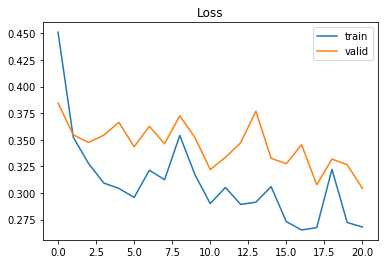

In [21]:
plt.plot(np.mean(train_hist[:21, :, 4], axis=1), label='train')
plt.plot(valid_hist[:21, 4], label='valid')
plt.title('Loss')
plt.legend();

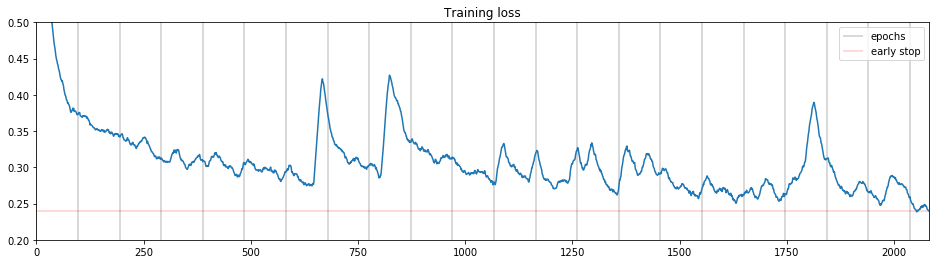

In [39]:
loss_hist = np.reshape(train_hist, (30 * 97, 5))[:2082, 4]
a = 20
avg_loss_hist = np.array([loss_hist[i - a: i].mean() for i in range(a, len(loss_hist))])
plt.figure(figsize=(16, 4))
plt.ylim(0.2, 0.5)
plt.xlim(0, len(loss_hist))
plt.plot(np.arange(a, len(loss_hist)), avg_loss_hist)
plt.vlines(np.arange(22) * 97, 0.2, 0.5, alpha=0.2, label='epochs')
plt.hlines(0.24, 0, len(loss_hist), alpha=0.2, color='r', label='early stop')
plt.title('Training loss')
plt.legend();

In [34]:
a_train = np.zeros(12)
F_train = np.zeros(12)
a_valid = np.zeros(12)
F_valid = np.zeros(12)

for e in range(12):
    tn = np.sum(train_hist[e, :, 0])
    fp = np.sum(train_hist[e, :, 1])
    fn = np.sum(train_hist[e, :, 2])
    tp = np.sum(train_hist[e, :, 3])
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    a_train[e] = a
    F_train[e] = F
    
    tn = valid_hist[e, 0]
    fp = valid_hist[e, 1]
    fn = valid_hist[e, 2]
    tp = valid_hist[e, 3]
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    
    a_valid[e] = a
    F_valid[e] = F

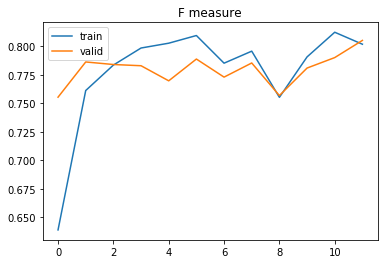

In [35]:
plt.plot(F_train, label='train')
plt.plot(F_valid, label='valid')
plt.title('F measure')
plt.legend();

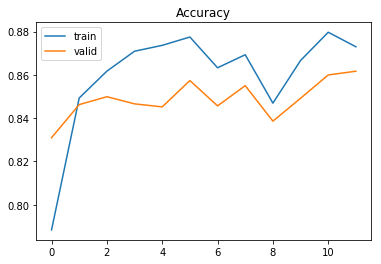

In [36]:
plt.plot(a_train, label='train')
plt.plot(a_valid, label='valid')
plt.title('Accuracy')
plt.legend();

In [37]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  6787 | fp:  1192 |
| fn:  1711 | tn: 13972 |
 -----------------------
 Accuracy: 0.8773
Precision: 0.8506
   Recall: 0.7987
F-measure: 0.8238
     Loss: 0.3011


# Import saved model

In [ ]:
model = beatfinder.model.BeatFinder()
model.load_state_dict(torch.load('./data/pretrained-models/model_11.pt', map_location=device))
model.to(device)
model.eval()
model.freeze()

# Look at an example of a prediction

In [40]:
dataset = validset
dataset.transform = None

73/420


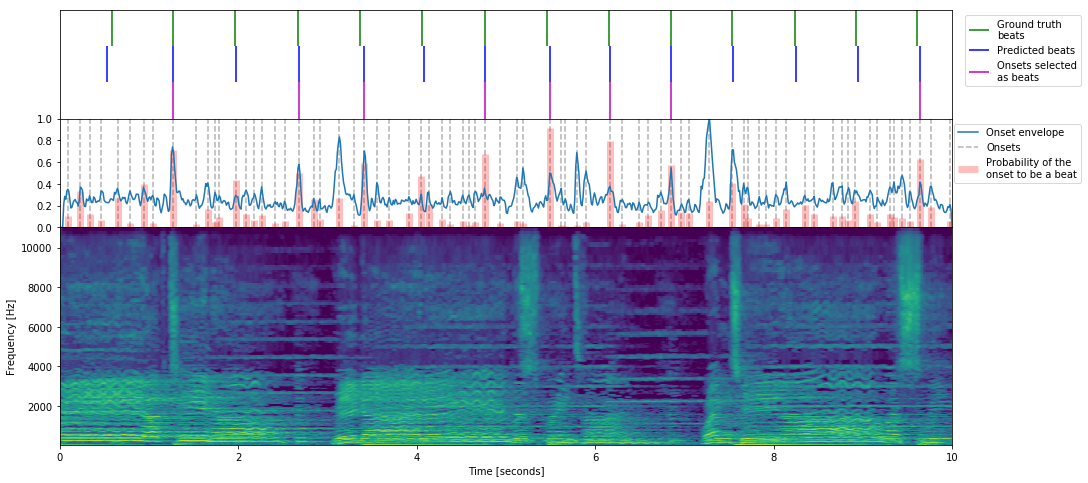

In [41]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
audiobeats = dataset[i]
audiobeats.predict(model, device)
audiobeats.showdata(beatfinder=model, device=device)

In [43]:
predicted_beats, bpm = audiobeats.predicted_beats()
ground_truth_beats = audiobeats.get_beats()
tp, fn, fp = beatfinder.utils.tp_fn_fp(ground_truth_beats, predicted_beats)
F = beatfinder.utils.F(tp, fn, fp)
print(f"F-score: {F:.3f}")

F-score: 1.000


In [ ]:
# Go back to the ground truth to don't mess up with training data.
audiobeats.precompute_onsets_and_isbeat()

# Evaluate the model on the validation set and compare with LibROSA

The next cell computes the F-measure of the model on the validation set, where two beats are considered the same if they are less than 0.07 second apart.

In [44]:
tp, fn, fp = beatfinder.utils.evaluate_dataset(validset, model, totensor)
F = beatfinder.utils.F(tp, fn, fp)
print(f'Model\'s F measure: {F:.4f}')

Model's F measure: 0.8349


Same thing but with LibROSA instead for comparison.

In [46]:
tp, fn, fp = beatfinder.utils.evaluate_dataset(validset, 'librosa')
F = beatfinder.utils.F(tp, fn, fp)
print(f'Librosa\'s F measure: {F:.4f}')

Librosa's F measure: 0.6596
